In [1]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
from scipy.stats import *
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns # informative statistical graphics.
import statsmodels.api as sm #for ARIMA and SARIMAX
import datetime
from datetime import timedelta


sns.set_style('darkgrid') #set color style for plot

In [2]:
#importing dataset for API

train = pd.read_csv('C:/Users/Sravan sravzz/Downloads/state_wise_daily.csv')

#DF = DF[:-1]
# train = train[:-1]

train['Date'] = pd.to_datetime(train['Date'], format="%d-%b-%y")
train1=pd.DataFrame(train)
train.head()

,Date,Date_YMD,Status,TT,AN,AP,AR,AS,BR,CH,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
0,2020-03-14,2020-03-14,Confirmed,81,0,1,0,0,0,0,...,1,3,0,1,1,0,12,0,0,0
1,2020-03-14,2020-03-14,Recovered,9,0,0,0,0,0,0,...,0,1,0,0,0,0,4,0,0,0
2,2020-03-14,2020-03-14,Deceased,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-03-15,2020-03-15,Confirmed,27,0,0,0,0,0,0,...,0,1,0,0,2,0,1,0,0,0
4,2020-03-15,2020-03-15,Recovered,4,0,0,0,0,0,0,...,0,2,0,0,1,0,0,0,0,0


In [3]:
#Since we are predicting total Recovery cases ('TT') column we don't need state data ,hence droping out state data

cols = ['AN','AP',	'AR',	'AS',	'BR',	'CH',	'CT',	'DD',	'DL',	'DN',	'GA',	'GJ',	'HP',	'HR',	'JH', 'JK',	'KA',	'KL',	'LA',	'LD',	'MH',	'ML',	'MN',	'MP',	'MZ',	'NL',	'OR',	'PB',	'PY',	'RJ',	'SK',	'TG',	'TN',	'TR',	'UP',	'UT',	'WB']
#cols1=['AN','AP',	'AR',	'AS',	'BR',	'CH',	'CT',	'DD',	'DN',	'GA',	'GJ',	'HP',	'HR',	'JH', 'JK',	'KA',	'KL',	'LA',	'LD',	'ML',	'MN',	'MP',	'MZ',	'NL',	'OR',	'PB',	'PY',	'RJ',	'SK',	'TG',	'TR',	'UP',	'UT',	'WB']
train.drop(cols, axis=1, inplace=True)
train = train.set_index('Status')
train.drop(['Confirmed','Deceased'],inplace=True)
train = train.reset_index()
train.drop(["Status"],axis=1,inplace= True)


In [4]:
train.tail()

,Date,Date_YMD,TT,UN
249,2020-11-18,2020-11-18,48675,0
250,2020-11-19,2020-11-19,45246,0
251,2020-11-20,2020-11-20,48968,0
252,2020-11-21,2020-11-21,44055,0
253,2020-11-22,2020-11-22,41405,0


In [5]:
# # copying data into train_df Dataframe so that our orignal data is untouched 

train_df = train

train_df.head()

,Date,Date_YMD,TT,UN
0,2020-03-14,2020-03-14,9,0
1,2020-03-15,2020-03-15,4,0
2,2020-03-16,2020-03-16,1,0
3,2020-03-17,2020-03-17,1,0
4,2020-03-18,2020-03-18,0,0


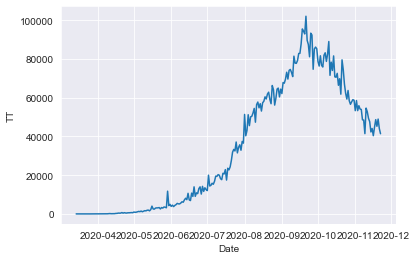

In [6]:
#plotting current data

sns.lineplot(x="Date", y="TT",legend = 'full' , data=train_df)

In [7]:
#setting 'date' column as index columna as forecasting will be done for this column
#making 'TT' as float for statistical calculations

train_df = train_df.set_index('Date')
train_df['TT'] = train_df['TT'].astype(float)

train_df.head()

,Date_YMD,TT,UN
Date,,,
2020-03-14,2020-03-14,9.0,0
2020-03-15,2020-03-15,4.0,0
2020-03-16,2020-03-16,1.0,0
2020-03-17,2020-03-17,1.0,0
2020-03-18,2020-03-18,0.0,0


<Figure size 432x288 with 0 Axes>

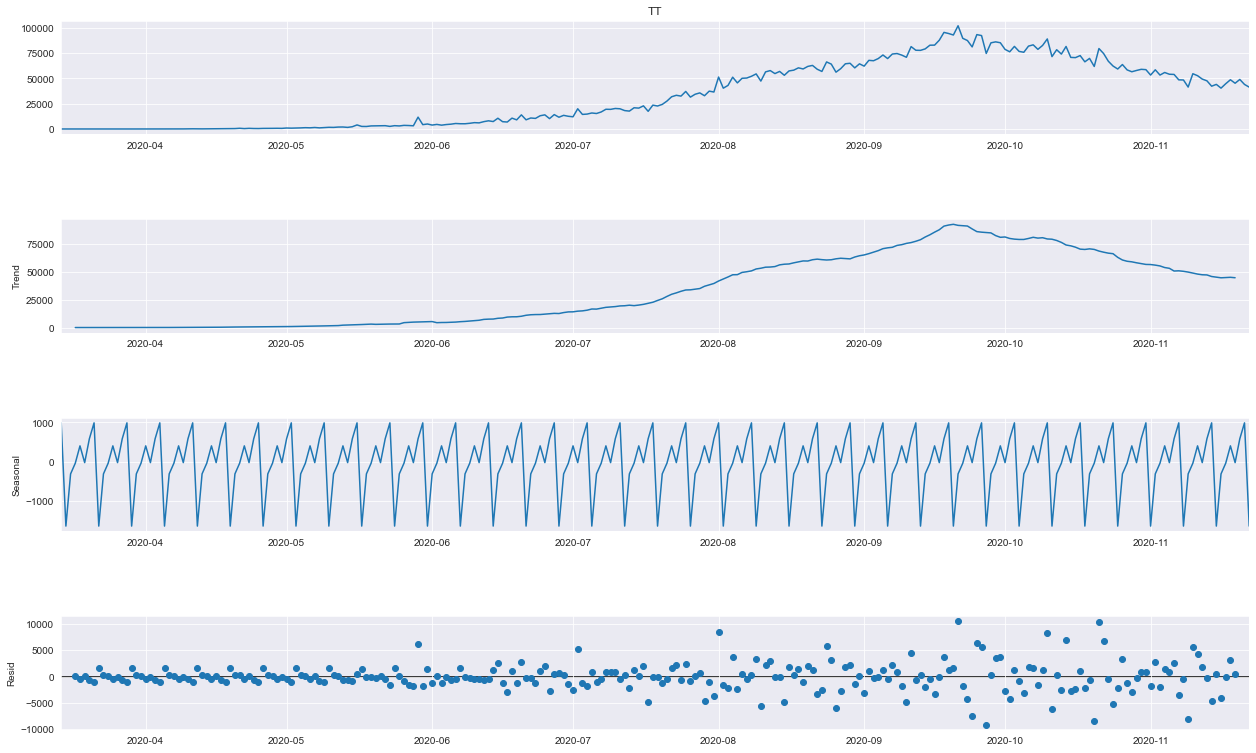

In [8]:
#Decomposing data to observe if there exists a sesional trend

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_df['TT'], model='additive')

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(20, 12)

The 'trend' graph has a upward growth which shows that the data is not stationary. Time Series forecasting can be done on stationary data and hence we need to nake it stationary.

In [9]:
from statsmodels.tsa.stattools import adfuller #adfuller stands for Augmented Dickey-Fuller unit root test.

#The function find mean and standard deviation of the series and and performs augmented dickey fuller test.
#returns pvale .. The samaller the pvalue more stationary is the series.

def test_stationarity(timeseries, window = 15, cutoff = 0.01):
  rolmean = timeseries.rolling(window).mean()
  rolstd = timeseries.rolling(window).std()
  fig = plt.figure(figsize=(12, 8))
  orig = plt.plot(timeseries, color='blue',label='Original')
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label = 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show()

  print('Results of Dickey-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC',)
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value
  pvalue = dftest[1]
  if pvalue < cutoff:
      print('p-value = %.4f. The series is likely stationary.' % pvalue)
  else:
      print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
  
  print(dfoutput)

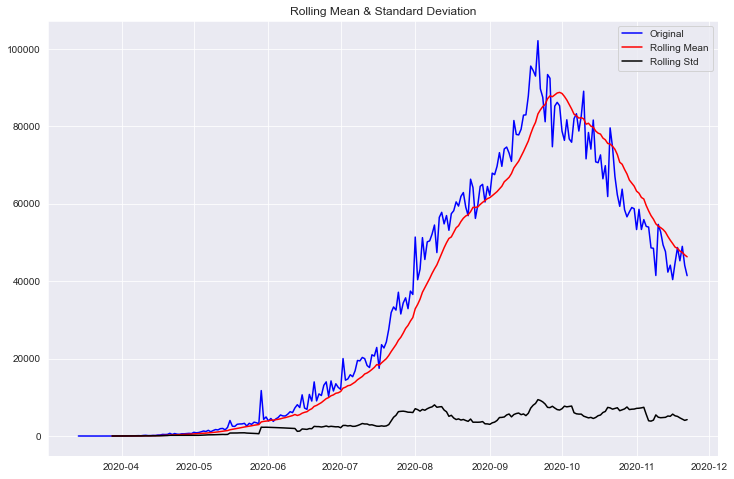

Results of Dickey-Fuller Test:
p-value = 0.5442. The series is likely non-stationary.
Test Statistic                  -1.478353
p-value                          0.544191
#Lags Used                      15.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


In [10]:
test_stationarity(train_df['TT'])

#calling the function gives below result , where we can observe the huge gap between orignal data and mean,std
#also the pvalue is 0.9778 which is not so good and hence , the output says "The series is likely non-stationary."

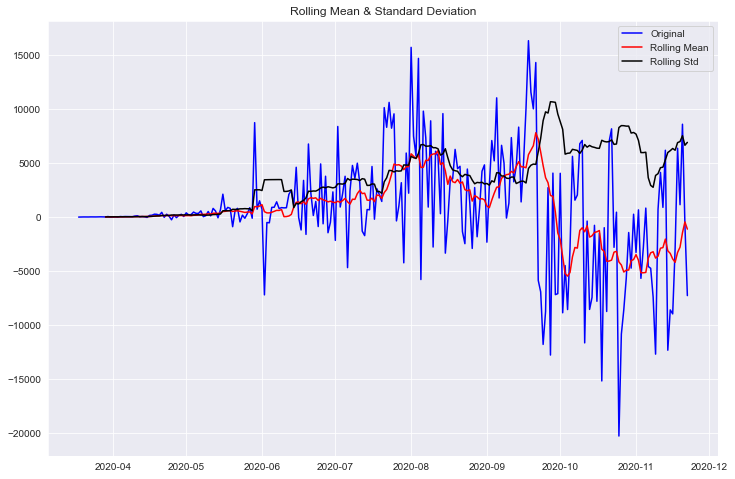

Results of Dickey-Fuller Test:
p-value = 0.1883. The series is likely non-stationary.
Test Statistic                  -2.250973
p-value                          0.188268
#Lags Used                      15.000000
Number of Observations Used    234.000000
Critical Value (1%)             -3.458608
Critical Value (5%)             -2.873972
Critical Value (10%)            -2.573396
dtype: float64


In [11]:
#here are various methods for making series stationary like log, differencing and so on..
#here we are using differencing , shift operator shifts the 'TT' cloumn of df by 4 places and difference is taken.

#plotting the data after differencing we see the pvalue is reduced to 0.3427 which is quite good as compared to our previous value 0.9778
#you can try different values in shift to reduce the pvalue (if possible , #try to choose one where number of observations used is MAX abd pval is MIN)

first_diff = train_df.TT - train_df.TT.shift(4)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

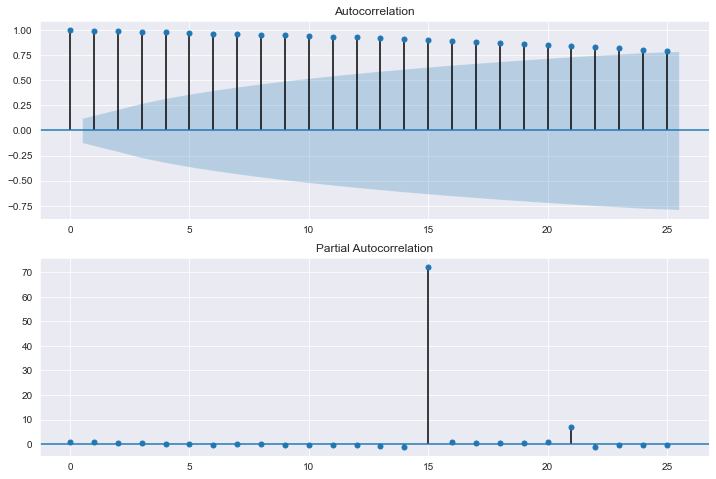

In [12]:
#plotting autocorrelation and partial autocorrelation for both data (data before differencing and data after differencing)

import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.TT, ax=ax1, ) # using default value of lag
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df.TT, ax=ax2) # using default value of lag

Here in partial autocorrelation we can see a small upward trend for ( almost ) every second plot as compared to previous plot. 

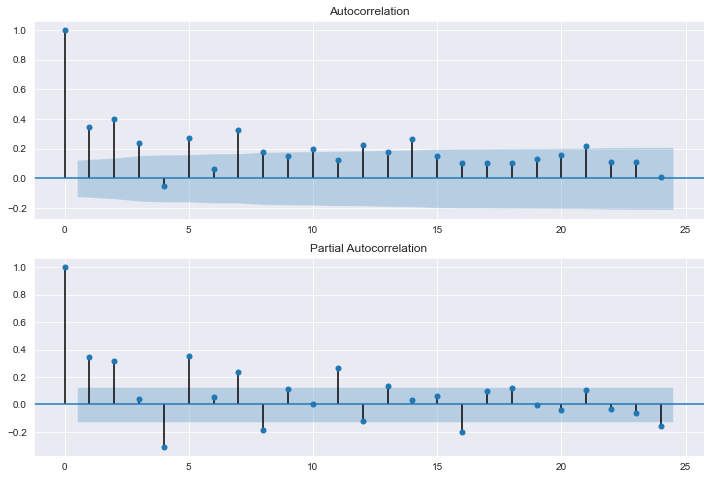

In [13]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, ax=ax2)

In [14]:
# we can see a recurring correlation exists in both ACF and PACF hece we should choose SARIMAX model which also deals with seasonality

#RULE : A model with no orders of differencing assumes that the original series is stationary (mean-reverting). A model with one order of differencing assumes that 
      #the original series has a constant average trend (e.g. a random walk or SES-type model, with or without growth). A model with two orders of total differencing assumes that 
      #the original series has a time-varying trend 

#Since our series has a contant average trend ( with growth ) we would take I = 1 and MA = 0 ( I-1 ).


sarimax_mod = sm.tsa.statespace.SARIMAX(train_df.TT, trend='n', order=(14,1,0)).fit()
print(sarimax_mod.summary())

C:\Users\Sravan sravzz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\Sravan sravzz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                     TT   No. Observations:                  254
Model:              SARIMAX(14, 1, 0)   Log Likelihood               -2414.797
Date:                Sat, 28 Nov 2020   AIC                           4859.594
Time:                        23:46:14   BIC                           4912.595
Sample:                    03-14-2020   HQIC                          4880.918
                         - 11-22-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5234      0.049    -10.578      0.000      -0.620      -0.426
ar.L2         -0.2587      0.062     -4.140      0.000      -0.381      -0.136
ar.L3         -0.0970      0.072     -1.339      0.1

NormaltestResult(statistic=26.341432540246426, pvalue=1.9055949848907509e-06)


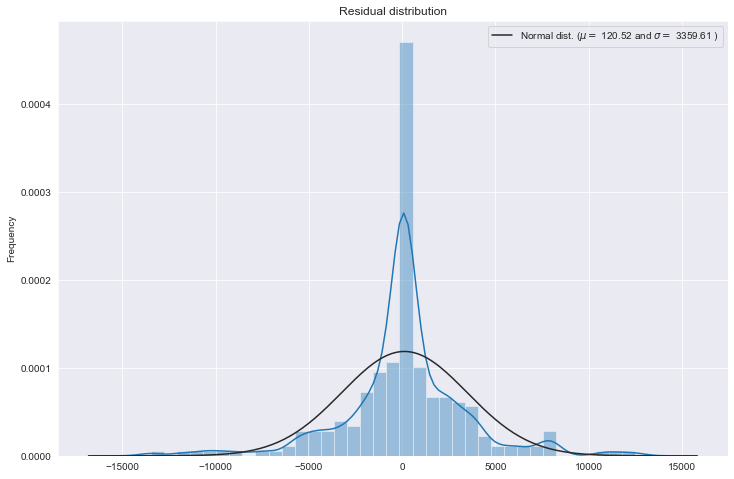

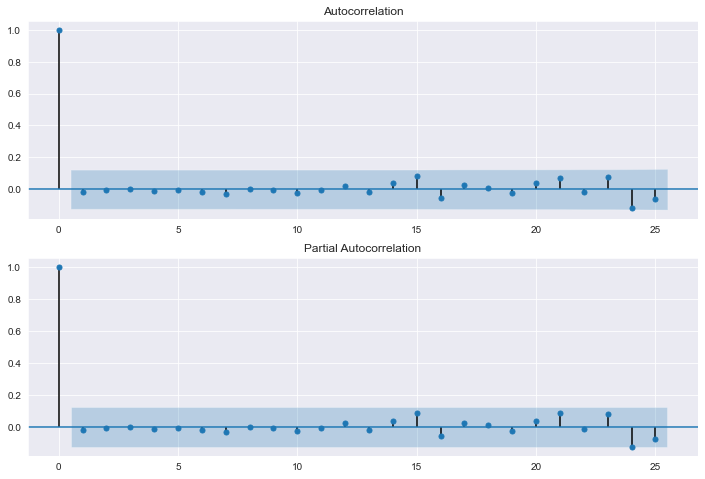

In [15]:
import scipy.stats as stats

resid = sarimax_mod.resid #gives residual degree of freedom (mu, sigma, pvalue ... )
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarimax_mod.resid, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarimax_mod.resid, ax=ax2)

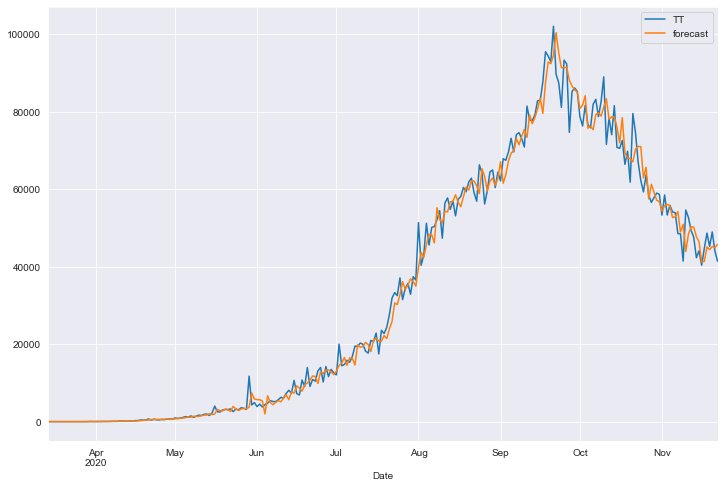

In [16]:
#Now lets predict using out model.
today = datetime.date.today() -timedelta(days=1)

start_index = '14-Mar-20'
end_index = today.strftime("%Y-%m-%d")

#adding forecasted values and plotting
train_df['forecast'] = sarimax_mod.predict(start= start_index,end = end_index,dynamic= False,)  

train_df[start_index:][['TT', 'forecast']].plot(figsize=(12, 8))

In [17]:
#lets predict for upcomming dates ..

future_predict = sarimax_mod.predict(start= datetime.date.today() ,end = datetime.date.today()+timedelta(days=30) ,dynamic= True,)

C:\Users\Sravan sravzz\anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2012: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


In [18]:
future_predict

2020-11-28    42563.149889
2020-11-29    41629.903891
2020-11-30    40580.953767
2020-12-01    41902.825723
2020-12-02    42458.548373
2020-12-03    40880.072170
2020-12-04    41241.292831
2020-12-05    40607.357019
2020-12-06    40745.086869
2020-12-07    40316.649846
2020-12-08    40466.770554
2020-12-09    40876.447001
2020-12-10    39989.879886
2020-12-11    40309.476140
2020-12-12    40135.189709
2020-12-13    39949.578687
2020-12-14    39773.964156
2020-12-15    39879.169991
2020-12-16    40060.555088
2020-12-17    39527.703238
2020-12-18    39615.833888
2020-12-19    39584.204775
2020-12-20    39582.856174
2020-12-21    39376.778029
2020-12-22    39378.525722
2020-12-23    39537.754687
2020-12-24    39244.884377
2020-12-25    39281.602986
2020-12-26    39229.886202
2020-12-27    39236.193472
2020-12-28    39154.111525
Freq: D, dtype: float64

In [19]:
# train_df=train_df.reset_index()
# train_df.head()

In [20]:
# dates=[]
# for i in future_predict.index:
#     if type(i)==type(future_predict.index[0]):
#       dates.append(i)
# data=[]
# for i in future_predict.values:
#   if type(i)==type(future_predict.values[0]):
#     data.append(i)

In [21]:
# train_df=train_df.reset_index()
# DF=pd.DataFrame({'forecast':data,'date':dates})
# train_df=train_df.append(DF)
# train_df=train_df.reset_index()
# train_df = train_df.set_index('date')
# train_df[start_index:][['TT', 'forecast']].plot(figsize=(12, 8))

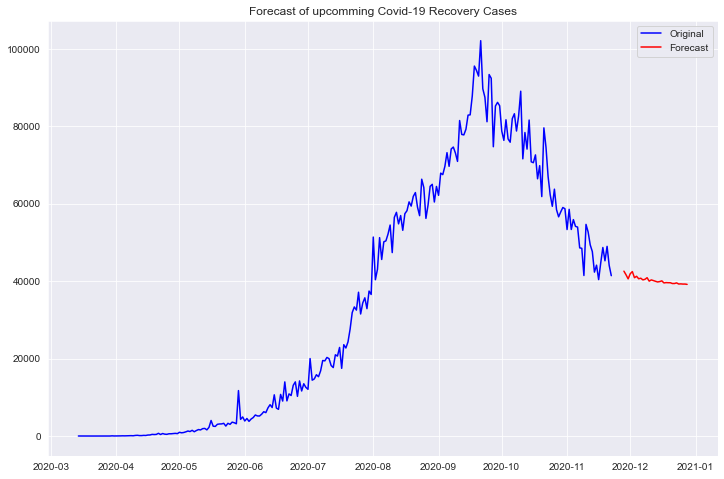

In [22]:
figg = plt.figure(figsize=(12, 8))
orig = plt.plot(train_df['TT'], color='blue',label='Original')
fore = plt.plot(future_predict, color='red', label='Forecast')
plt.legend(loc='best')
plt.title('Forecast of upcomming Covid-19 Recovery Cases')
plt.show()

In [23]:
f_temp = pd.DataFrame()

In [24]:
f_temp['date'] = future_predict.index
f_temp['values'] = future_predict.values

In [25]:
f_temp

,date,values
0,2020-11-28,42563.149889
1,2020-11-29,41629.903891
2,2020-11-30,40580.953767
3,2020-12-01,41902.825723
4,2020-12-02,42458.548373
5,2020-12-03,40880.072170
6,2020-12-04,41241.292831
7,2020-12-05,40607.357019
8,2020-12-06,40745.086869
9,2020-12-07,40316.649846


In [26]:
f_temp.loc[-1] = [train_df.index[-1],train_df['TT'][-1]]

In [27]:
f_temp

,date,values
0,2020-11-28,42563.149889
1,2020-11-29,41629.903891
2,2020-11-30,40580.953767
3,2020-12-01,41902.825723
4,2020-12-02,42458.548373
5,2020-12-03,40880.072170
6,2020-12-04,41241.292831
7,2020-12-05,40607.357019
8,2020-12-06,40745.086869
9,2020-12-07,40316.649846


In [28]:
f_temp.index = f_temp.index + 1

In [29]:
#f_temp = f_temp.sort_index()
f_temp

,date,values
1,2020-11-28,42563.149889
2,2020-11-29,41629.903891
3,2020-11-30,40580.953767
4,2020-12-01,41902.825723
5,2020-12-02,42458.548373
6,2020-12-03,40880.072170
7,2020-12-04,41241.292831
8,2020-12-05,40607.357019
9,2020-12-06,40745.086869
10,2020-12-07,40316.649846


In [30]:
# f_temp.drop(1,inplace=True)
f_temp = f_temp.sort_index()
f_temp

,date,values
0,2020-11-22,41405.000000
1,2020-11-28,42563.149889
2,2020-11-29,41629.903891
3,2020-11-30,40580.953767
4,2020-12-01,41902.825723
5,2020-12-02,42458.548373
6,2020-12-03,40880.072170
7,2020-12-04,41241.292831
8,2020-12-05,40607.357019
9,2020-12-06,40745.086869


In [31]:
f_temp['date'] = pd.to_datetime(f_temp['date'], format="%d-%b-%y")
f_temp = f_temp.set_index('date')

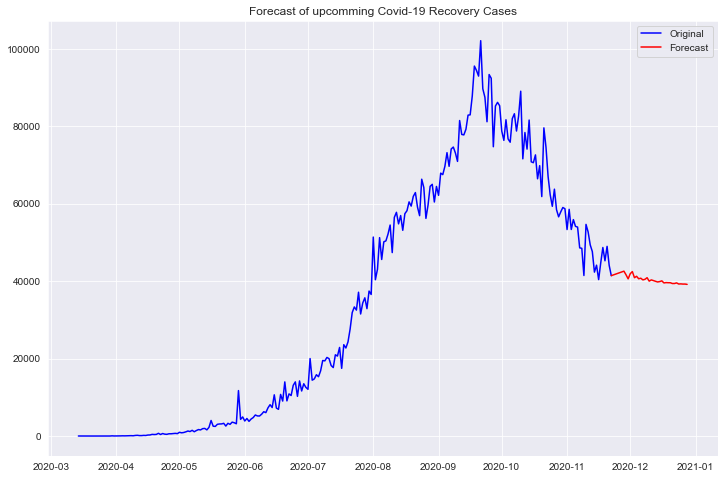

In [32]:
figg = plt.figure(figsize=(12, 8))
orig = plt.plot(train_df['TT'], color='blue',label='Original')
fore = plt.plot(f_temp['values'], color='red', label='Forecast')
plt.legend(loc='best')
plt.title('Forecast of upcomming Covid-19 Recovery Cases')
plt.show()

In [33]:
fcast = sarimax_mod.get_forecast(datetime.date.today()+timedelta(days=30))
fcast = fcast.conf_int()
fcast

#This will give us confidence levels for our predictions

,lower TT,upper TT
2020-11-23,35150.138504,48733.835676
2020-11-24,35974.917127,51022.389470
2020-11-25,35727.130361,52191.289851
2020-11-26,32593.653716,50521.356844
2020-11-27,32631.193953,52420.942779
2020-11-28,31663.102138,53463.197639
2020-11-29,30368.025260,52891.782522
2020-11-30,28137.257722,53024.649813
2020-12-01,28299.565158,55506.086289
2020-12-02,28017.116708,56899.980039


In [34]:
fcast = fcast.reset_index()
fcast.loc[-1] = [train_df.index[-1],train_df['TT'][-1],train_df['TT'][-1]]
fcast.index = fcast.index + 1
fcast = fcast.sort_index()
fcast['index'] = pd.to_datetime(fcast['index'], format="%d-%b-%y")
fcast = fcast.set_index('index')
fcast

,lower TT,upper TT
index,,
2020-11-22,41405.000000,41405.000000
2020-11-23,35150.138504,48733.835676
2020-11-24,35974.917127,51022.389470
2020-11-25,35727.130361,52191.289851
2020-11-26,32593.653716,50521.356844
2020-11-27,32631.193953,52420.942779
2020-11-28,31663.102138,53463.197639
2020-11-29,30368.025260,52891.782522
2020-11-30,28137.257722,53024.649813


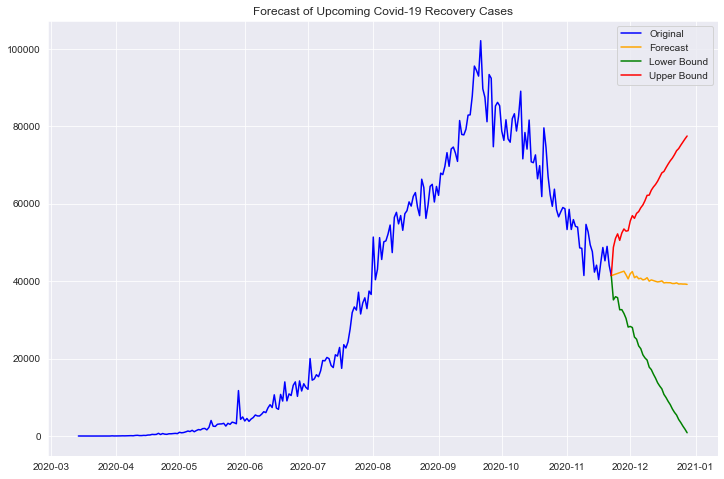

In [35]:
figg = plt.figure(figsize=(12, 8))
orig = plt.plot(train_df['TT'], color='blue',label='Original')
fore = plt.plot(f_temp['values'], color='orange', label='Forecast')
lower = plt.plot(fcast['lower TT'], color='green', label='Lower Bound')
upper = plt.plot(fcast['upper TT'], color='red', label='Upper Bound')
plt.legend(loc='best')
plt.title('Forecast of Upcoming Covid-19 Recovery Cases')
plt.show()